## Visualizing data from the MRR-PRO

This notebooks shows how to visualize data from the MRR-PRO at NEIU. 

The first cell here loads the necessary libraries:
    * Py-ART
    * xarray
    * sage_data_client
    * matplotlib
    * numpy

In [704]:
import matplotlib.pyplot as plt
import numpy as np
import pyart
import sage_data_client
import xarray as xr
import requests
import tempfile
import getpass
import os

from scipy.ndimage import find_objects, label, median_filter
%matplotlib inline

In [785]:
df = sage_data_client.query(
            start="-1h",
            filter={"vsn": "W08D", "name": "upload", "task": "mrrpro",
                    }).set_index("timestamp")

In [786]:
df['value'].values[:]

array(['https://storage.sagecontinuum.org/api/v1/data/mrrpro/sage-mrrpro-0.1.2/000048b02d3ae277/1696010594339422862-20230929_170000.nc'],
      dtype=object)

The below code will grab the list of files. Some time periods are duplicated from testing the plugin, so we remove the duplicates here.

In [787]:
file_list = list(df.value.values)

cur_time = ""
for f in file_list:
    time_stamp = f[-18:]
    if cur_time == time_stamp:
        file_list.remove(f)
    else:
        cur_time = time_stamp

In [788]:
file_list

['https://storage.sagecontinuum.org/api/v1/data/mrrpro/sage-mrrpro-0.1.2/000048b02d3ae277/1696010594339422862-20230929_170000.nc']

Get credentials for logging into the Beehive server. We are working to make this access public
without a password. Please ask a core Waggle developer (Bobby, Max, Scott) for the username and password credentials.

In [789]:
username = 'waggle'
password = '!4PublicHideMe'

This code will download the MRR data from Beehive and then concatenate the results
into a single xarray dataset.

In [791]:
if not os.path.exists('mrr_data'):
    os.mkdir('mrr_data')
    
def readtofile(uurl, ff, username, password):
    r = requests.get(uurl, auth=(username,password))
    if r.status_code == 200:
        print('Downloading %s' % uurl[-18:])
        with open(ff, 'wb') as out:
            for bits in r.iter_content():
                out.write(bits)
    
    return True
    
temp_file_list = []
for f in file_list:
    name = f[-18:]
    out_name = 'mrr_data/%s' % name
    if not os.path.exists(out_name):
        readtofile(f, out_name, username, password)
    if not out_name in temp_file_list:
        temp_file_list.append(out_name)

https://storage.sagecontinuum.org/api/v1/data/mrrpro/sage-mrrpro-0.1.2/000048b02d3ae277/1696010594339422862-20230929_170000.nc


Load the downloaded files into an xarray dataset.

In [784]:
ds = xr.open_mfdataset('mrr_data/20230929_170000.nc')

OSError: no files to open

Let's preview the xarray dataset's contents! Example variables that are recorded by the MRR-PRO are:

    * Ze, which is the equivalent reflectivity. This shows the intensity of precipitation.
    * VEL, the Doppler velocity. This shows how quickly the detected objects are falling toward the MRR-PRO.
    * SNR, signal to noise ratio. Ratios < 1 show where the MRR-PRO signal is weak and likely noise.
    * spectra_raw, the raw signal from the MRR as a function of frequency.
    

In [783]:
ds

<xarray.Dataset>
Dimensions:                 (time: 8640, range: 256, sweep: 1, n_spectra: 256,
                             spectrum_n_samples: 32)
Coordinates:
  * range                   (range) float32 0.0 35.0 70.0 ... 8.89e+03 8.925e+03
  * time                    (time) datetime64[ns] 2023-05-24T00:00:00.0065789...
    elevation               (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
    azimuth                 (time) float32 dask.array<chunksize=(360,), meta=np.ndarray>
Dimensions without coordinates: sweep, n_spectra, spectrum_n_samples
Data variables: (12/31)
    volume_number           (time) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    time_coverage_start     (time) |S128 b'2023-05-24T00:00:00Z' ... b'2023-0...
    time_coverage_end       (time) |S128 b'2023-05-24T00:59:50Z' ... b'2023-0...
    time_reference          (time) |S128 b'1970-01-01T00:00:00Z' ... b'1970-0...
    instrument_type         (time) |S128 b'radar' b'radar' ... b'radar' b'radar'
    transfer_function       (time, range) float64 dask.array<chunksize=(360, 256), meta=np.ndarray>
    ...                      ...
    ML                      (time, range) float64 dask.array<chunksize=(360, 256), meta=np.ndarray>
    SNR                     (time, range) float32 dask.array<chunksize=(360, 256), meta=np.ndarray>
    index_spectra           (time, range) float64 dask.array<chunksize=(360, 256), meta=np.ndarray>
    spectrum_raw            (time, n_spectra, spectrum_n_samples) float64 dask.array<chunksize=(360, 256, 32), meta=np.ndarray>
    N                       (time, n_spectra, spectrum_n_samples) float64 dask.array<chunksize=(360, 256, 32), meta=np.ndarray>
    D                       (time, n_spectra, spectrum_n_samples) float64 dask.array<chunksize=(360, 256, 32), meta=np.ndarray>
Attributes:
    Conventions:      CF/Radial
    version:          1.3
    title:            METEK MRR Pro 1.2.5 Data
    institution:      
    references:       
    source:           
    history:          
    comment:          
    instrument_name:  METEK MRR Pro 1.2.5, ID: MRRPro97, METEK Serial Number:...
    site_name:        cms-mrr-002
    field_names:      Za,Z,Zea,Ze,RR,LWC,PIA,VEL,WIDTH,SNR,spectrum_reflectiv...

Let's look at Ze, the equivalent reflectivity.

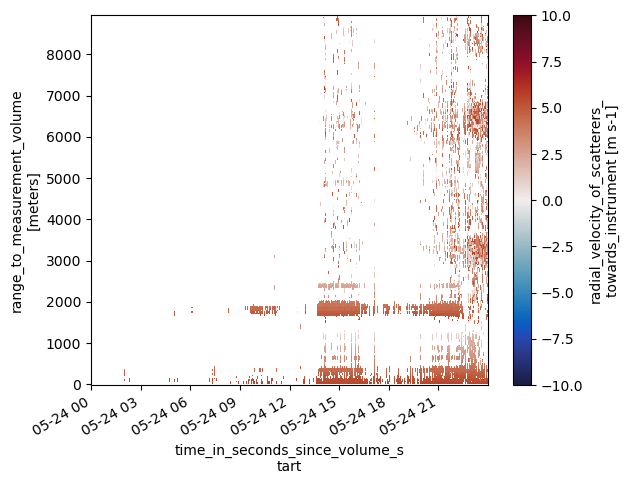

In [33]:
ds["VEL"].T.plot(cmap='pyart_balance', vmin=-10, vmax=10)

In [756]:
ds_spec = xr.open_dataset('mrr_data/ERUO_20230815_000000.nc')
ds_spec

<xarray.Dataset>
Dimensions:                       (time: 360, range: 256,
                                   spectrum_n_samples_extended: 96,
                                   spectrum_n_samples: 32)
Coordinates:
  * range                         (range) float32 0.0 35.0 ... 8.925e+03
  * time                          (time) datetime64[ns] 2023-08-15T00:00:00.0...
    elevation                     (time) float32 ...
    azimuth                       (time) float32 ...
Dimensions without coordinates: spectrum_n_samples_extended, spectrum_n_samples
Data variables:
    spectrum_reflectivity         (time, range, spectrum_n_samples_extended) float64 ...
    Zea                           (time, range) float64 ...
    VEL                           (time, range) float64 ...
    WIDTH                         (time, range) float64 ...
    SNR                           (time, range) float64 ...
    noise_level                   (time, range) float64 ...
    noise_floor                   (time, range) float64 ...
    flag_spectrum_reconstruction  (time, range, spectrum_n_samples) float64 ...
Attributes:
    Conventions:      CF/Radial
    version:          1.3
    title:            METEK MRR Pro 1.2.5 Data - Re-processed with ASPRO
    institution:      
    references:       
    source:           
    history:          Re-processed with ASPRO on 26/09/2023 18:59:18 UTC
    comment:          
    instrument_name:  METEK MRR Pro 1.2.5, ID: MRRPro97, METEK Serial Number:...
    site_name:        cms-mrr-002
    field_names:      spectrum_reflectivity,Zea,VEL,WIDTH,SNR,noise_level,noi...

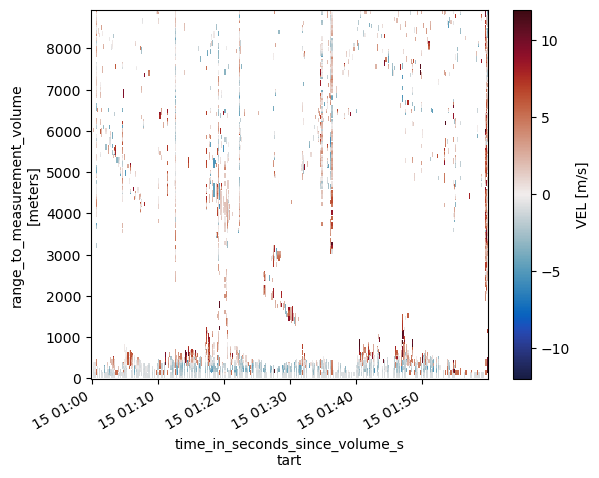

In [754]:
ds_spec["VEL"].T.plot(vmin=-12, vmax=12, cmap='pyart_balance')

In [755]:
def 

SyntaxError: invalid syntax (1885169875.py, line 1)

In [739]:
def correct_spectra(ds, nyq_vel=6.15):
    spec = ds["spectrum_reflectivity"].values.copy()
    ref_sum = np.cumsum(np.nan_to_num(10**spec, 0), axis=2)
    middle_bin = np.zeros_like(ds["Zea"].values)
    for i in range(middle_bin.shape[0]):
        for j in range(middle_bin.shape[1]):
            temp = np.argwhere(ref_sum[i, j, :] < 0.5*ref_sum[i, j, -1])
            if len(temp) > 0:
                middle_bin[i, j] = temp[-1]
            else:
                middle_bin[i, j] = np.nan
    middle_bin = np.where(np.isfinite(ref_sum[:, :, -1]), middle_bin, np.nan)
    middle_bin_median = np.nanmedian(middle_bin)
    where_jump_time_pos = np.where(middle_bin - middle_bin_median > 16)
    where_jump_time_neg = np.where(middle_bin - middle_bin_median <= -16)
    #where_jump_time_pos = np.where(mid_bin_diff > 32)
    #where_jump_time_neg = np.where(mid_bin_diff < -32)
    for j in range(len(where_jump_time_pos[0])):    
        spec[where_jump_time_pos[0][j], where_jump_time_pos[1][j], :] = np.nan

    for j in range(len(where_jump_time_neg[0])):    
        spec[where_jump_time_neg[0][j], where_jump_time_neg[1][j], :] = np.nan
        
    inp_array = np.where(np.nansum(10**spec, axis=2) > 0, 1, 0)
    for j in range(spec.shape[0]):
        labels, num_features = label(inp_array[j])
        for k in range(num_features):
            if np.sum(labels == k) < 10:
                spec[j, labels == k, :] = np.nan
    ds["spectrum_reflectivity_centered"] = xr.DataArray(spec, dims=('time', 'range', 'spectrum_n_samples_extended'))
    vel_bins = np.linspace(-nyq_vel, 2 * nyq_vel, 96)
    dV = vel_bins[1] - vel_bins[0]
    mean_vel = np.nansum(10 ** (spec/10) * np.tile(vel_bins, (spec.shape[0], spec.shape[1], 1)) * dV, axis=2)
    mean_vel = mean_vel / np.nansum(10 ** (spec/10) * dV, axis=2)
    ds["vel_corrected"] = xr.DataArray(median_filter(mean_vel, 5, mode='constant'), dims=('time', 'range'))
    #ds["vel_corrected"] = ds["vel_corrected"].where(ds["SNR"] > ds["noise_level"])
    return ds

In [392]:
np.roll([3, 4, 5], -1)

array([4, 5, 3])

In [740]:
nyq_vel = 6.15
spec = ds_spec["spectrum_reflectivity"].values.copy()
ref_sum = np.cumsum(np.nan_to_num(10**spec, 0), axis=2)
middle_bin = np.zeros_like(ds_spec["Zea"].values)
for i in range(middle_bin.shape[0]):
    for j in range(middle_bin.shape[1]):
        temp = np.argwhere(ref_sum[i, j, :] < 0.5*ref_sum[i, j, -1])
        if len(temp) > 0:
            middle_bin[i, j] = temp[-1]
        else:
            middle_bin[i, j] = np.nan
middle_bin = np.where(np.isfinite(ref_sum[:, :, -1]), middle_bin, np.nan)
middle_bin_median = np.tile(np.nanmean(middle_bin, axis=0), (middle_bin.shape[0], 1))
where_jump_time_pos = np.where(middle_bin - middle_bin_median >= 16)
where_jump_time_neg = np.where(middle_bin - middle_bin_median <= -16)
#where_jump_time_pos = np.where(mid_bin_diff > 32)
#where_jump_time_neg = np.where(mid_bin_diff < -32)
print(where_jump_time_pos[0].shape)
for j in range(len(where_jump_time_pos[0])):    
    spec[where_jump_time_pos[0][j], where_jump_time_pos[1][j], :] = np.nan

for j in range(len(where_jump_time_neg[0])):    
    spec[where_jump_time_neg[0][j], where_jump_time_neg[1][j], :] = np.nan
    
inp_array = np.where(np.nansum(10**spec, axis=2) > 0, 1, 0)
for j in range(spec.shape[0]):
    labels, num_features = label(inp_array[j])
    for k in range(num_features):
        if np.sum(labels == k) < 10:
            spec[j, labels == k, :] = np.nan
    
ds_spec["spectrum_reflectivity_centered"] = xr.DataArray(spec, dims=('time', 'range', 'spectrum_n_samples_extended'))

vel_bins = np.linspace(-nyq_vel, 2 * nyq_vel, 96)
dV = vel_bins[1] - vel_bins[0]
mean_vel = np.nansum(10 ** (spec/10) * np.tile(vel_bins, (spec.shape[0], spec.shape[1], 1)) * dV, axis=2)
mean_vel = mean_vel / np.nansum(10 ** (spec/10) * dV, axis=2)

/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_21040/2311223057.py:13: RuntimeWarning: Mean of empty slice
  middle_bin_median = np.tile(np.nanmean(middle_bin, axis=0), (middle_bin.shape[0], 1))


(3096,)


/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_21040/2311223057.py:37: RuntimeWarning: invalid value encountered in divide
  mean_vel = mean_vel / np.nansum(10 ** (spec/10) * dV, axis=2)


In [654]:
label([1, 0, 0, 1, 1, 0])

(array([1, 0, 0, 2, 2, 0], dtype=int32), 2)

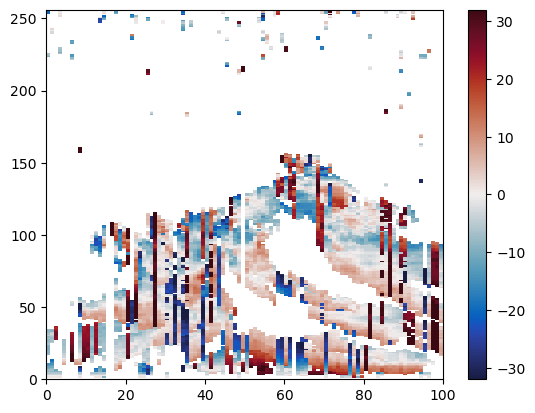

In [741]:
c = plt.pcolormesh(middle_bin[150:250].T - middle_bin_median[150:250].T, vmin=-32, vmax=32, cmap='pyart_balance')
plt.colorbar(c)

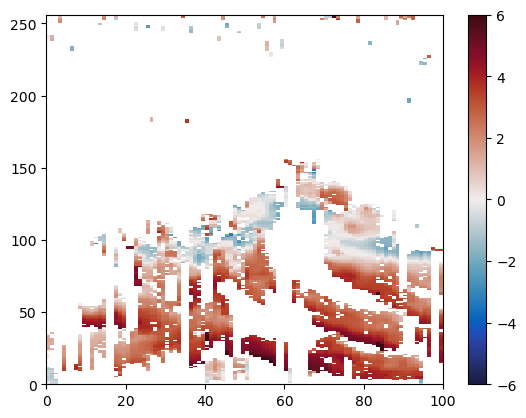

In [744]:
c = plt.pcolormesh(median_filter(mean_vel[150:250].T, 3, mode='constant'), vmin=-6, vmax=6, cmap='pyart_balance')
plt.colorbar(c)

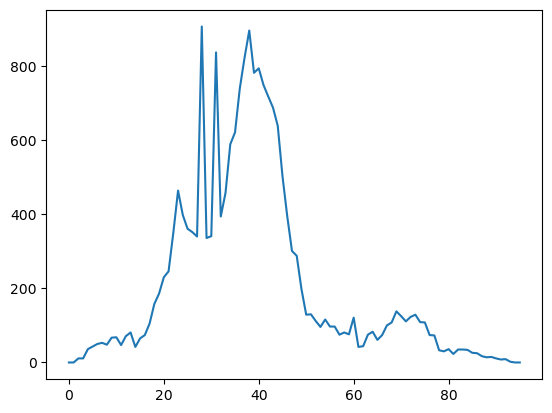

In [702]:
hist, bins = np.histogram(middle_bin, bins=np.arange(-1, 96, 1))
plt.plot(bins[1:], hist)

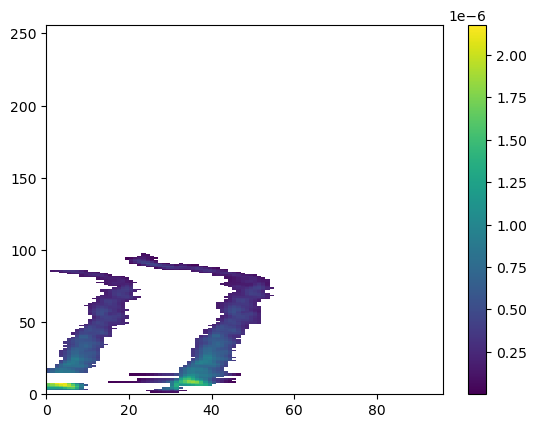

In [703]:
spec = ds_spec["spectrum_reflectivity"].values.copy()
c = plt.pcolormesh(10**(spec[196]/10))
plt.colorbar(c)

In [745]:
ds_spec = correct_spectra(ds_spec)

/var/folders/xf/43jvg_v90fx7z1sj2j1v8h0w0000gn/T/ipykernel_21040/2848940716.py:34: RuntimeWarning: invalid value encountered in divide
  mean_vel = mean_vel / np.nansum(10 ** (spec/10) * dV, axis=2)


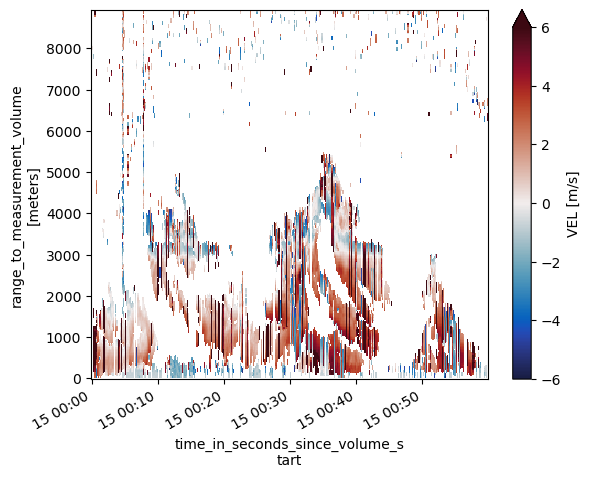

In [751]:
ds_spec["VEL"].where(ds_spec["SNR"] > ds_spec["noise_level"]).T.plot(vmin=-6, vmax=6, cmap='pyart_balance')
plt.savefig('vel_ERUO_no_filtering.png')

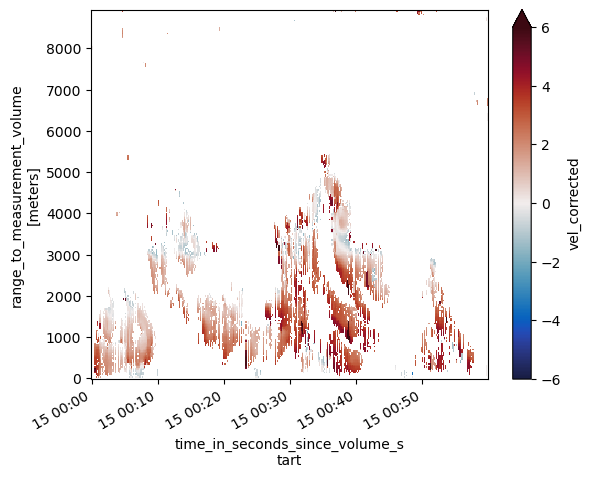

In [752]:
ds_spec["vel_corrected"].where(ds_spec["SNR"] > ds_spec["noise_level"]).T.plot(vmin=-6, vmax=6, cmap='pyart_balance')
plt.savefig('vel_ERUO_after_filtering.png')

In [126]:
q = ds['spectrum_raw'].sel(
    time=slice('2023-06-14T02:00:00', '2023-06-14T10:00:00')).load().quantile(
    dim='time', q=0.5)

KeyError: 'spectrum_raw'

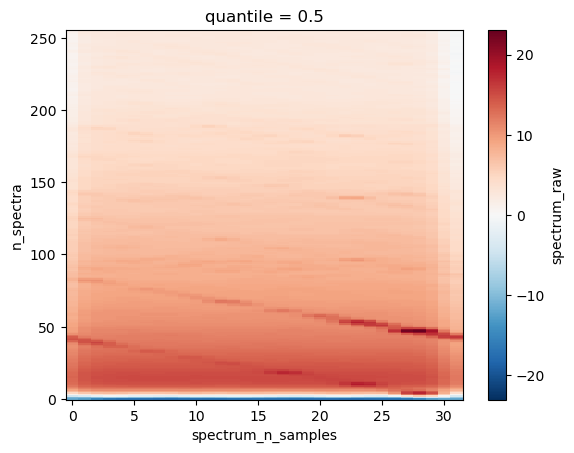

In [78]:
q.plot()
plt.savefig('raw_spectra.png')

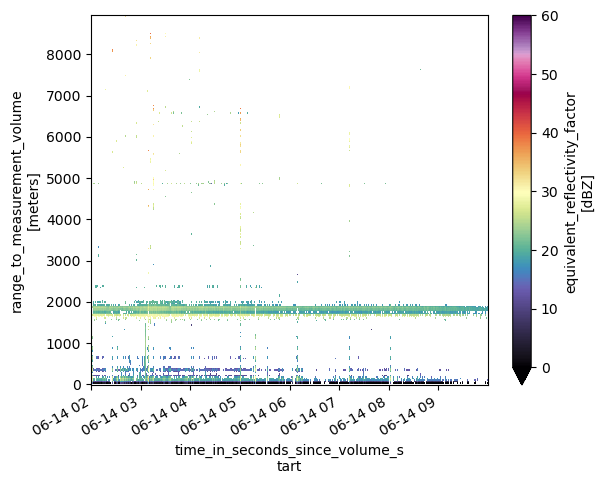

In [55]:
ds["Ze"].sel(time=slice('2023-06-14T02:00:00', '2023-06-14T10:00:00')).where(ds["SNR"] > -10).T.plot(cmap='pyart_ChaseSpectral', vmin=0, vmax=60)
plt.savefig('mrr_rain.png')

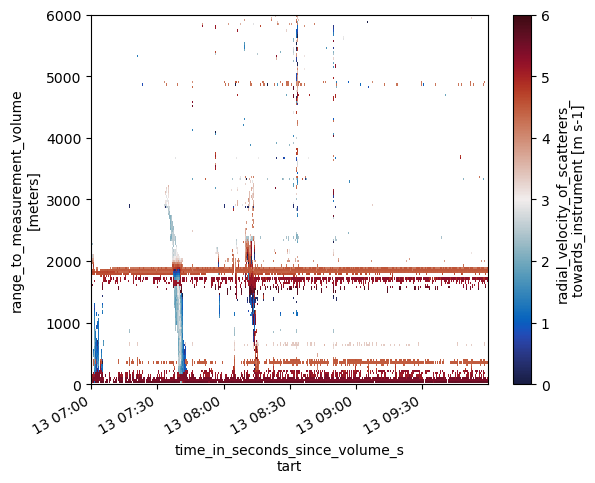

In [59]:
ds["VEL"].where(ds["SNR"] > -10).sel(time=slice('2023-06-13T07:00:00', '2023-06-13T10:00:00')).T.plot(cmap='pyart_balance', vmin=0, vmax=6)
plt.ylim([0, 6000])  
plt.savefig('mrr_rain.png')

The above plot shows some precipitation occurring around 20Z, so let's zoom into that!

(0.0, 6000.0)

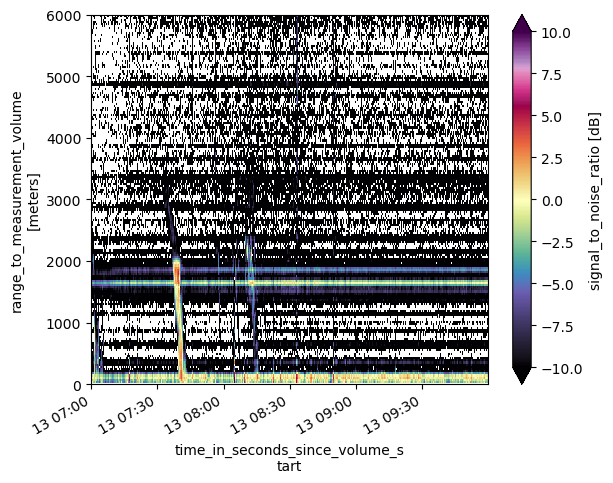

In [48]:
ds["SNR"].sel(time=slice('2023-06-13T07:00:00', '2023-06-13T10:00:00')).T.plot(
    cmap='pyart_ChaseSpectral', vmin=-10, vmax=10)
plt.ylim([0, 6000])   